In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('csv_out')
# 加载CSV文件
df = pd.read_csv(path/'tracking_data.csv')

# 按照车辆ID和时间排序
df.sort_values(by=['id', 'frame'], inplace=True)

In [3]:
df.head()

frame      time  id class  center_x  center_y  speed_kmh
0       1  0.034483   1   car       385       281        NaN
25      2  0.068966   1   car       385       281        NaN
49      3  0.103448   1   car       385       281        NaN
73      4  0.137931   1   car       385       281        NaN
97      5  0.172414   1   car       385       281        NaN

In [4]:
df =  df.groupby('id').apply(lambda x: x.iloc[::30]).reset_index(drop=True)

In [5]:

def get_tra_from_id(df, vehicle_id):
    return df[df['id'] == vehicle_id]

def plot_turning_per_sec(df, vehicle_id, deg_thresh=10):
    df['center_y_inverted'] = df['center_y'] * -1
    


    
    # 计算每个车辆在每个时间点的位移
    df.loc[:, 'delta_x'] = df.groupby('id')['center_x'].diff()
    df.loc[:, 'delta_y'] = df.groupby('id')['center_y_inverted'].diff()
    
    # 计算每个点的方向角（弧度），范围为 [-π, π]
    df.loc[:, 'theta'] = np.arctan2(df['delta_y'], df['delta_x'])

    # 计算方向角的变化量（角速度）
    df.loc[:, 'delta_theta'] = df.groupby('id')['theta'].diff()
    
    # 为了处理角度跳变的问题，将变化量限制在 [-π, π] 范围内
    df.loc[:, 'delta_theta'] = (df['delta_theta'] + np.pi) % (2 * np.pi) - np.pi
    
    # 填充缺失值
    df.loc[:, 'delta_theta'] = df['delta_theta'].fillna(0)
    
    # 设置角度变化累积的窗口大小，例如3秒（假设帧率为30帧/秒）
    window_size = 2  # 2秒 
    
    # 对角度变化进行累积和
    df.loc[:, 'cum_delta_theta'] = df.groupby('id')['delta_theta'].rolling(window_size).sum().reset_index(level=0, drop=True)
    
    # 设置窗口大小（可以根据需要调整）
    
    
    # 使用滑动窗口来计算累积方向变化
    df.loc[:, 'windowed_delta_theta'] = df['delta_theta'].rolling(window=window_size, min_periods=1).sum()
    
    # 设置阈值来判断转弯方向
    turn_threshold = np.deg2rad(deg_thresh)  # 15度的阈值
    
    # 初始化转弯标签
    df['turn_label'] = 'straight'  # 默认为直行
    
    # 计算像素上的移动距离
    df['distance_moved'] = np.sqrt(df['delta_x'] ** 2 + df['delta_y'] ** 2)
    
    # 将像素转换为米，1个像素对应 3.5/19 米
    df['distance_moved_meters'] = df['distance_moved'] * (3.5 / 19)
    
    # 设置移动距离的阈值，低于该阈值表示车辆没有实际移动
    movement_threshold = 0.5  # 阈值设为0.5米（可以根据实际情况调整）
    
    # 判断左转，仅当车辆实际移动的距离超过阈值时才标记为转弯
    df.loc[(df['windowed_delta_theta'] > turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'left_turn'
    
    # 判断右转
    df.loc[(df['windowed_delta_theta'] < -turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'right_turn'
    
    # 定义颜色映射，给 left_turn 和 right_turn 分配鲜艳的颜色
    color_map = {
        'left_turn': 'red',
        'right_turn': 'pink',
        'straight': 'yellow'
    }
    
    # 获取车辆轨迹数据
    # vehicle_df = get_tra_from_id(df, vehicle_id)
    vehicle_df = df
    
    plt.figure(figsize=(10, 8))
    
    # 绘制轨迹
    plt.plot(vehicle_df['center_x'], vehicle_df['center_y'], 'b.-', label='traj')
    
    # 根据转弯标签改变颜色
    for label, group in vehicle_df.groupby('turn_label'):
        plt.plot(group['center_x'], group['center_y'], '.', label=label, color=color_map.get(label, 'gray'))
    
    plt.gca().invert_yaxis()  # 反转 y 轴以匹配 OpenCV 的坐标系
    plt.legend()
    plt.xlabel('center x')
    plt.ylabel('center y')
    plt.title(f'vehicle {vehicle_id} trajectory and turning label at each time')
    return df
    
    # plt.show() 

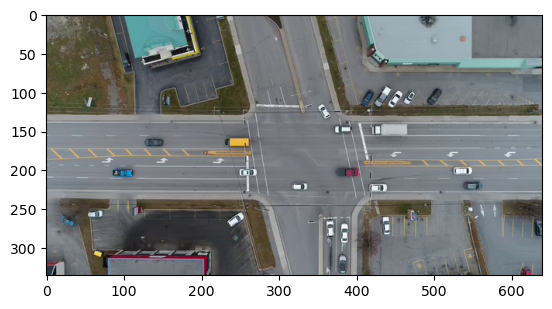

In [6]:
def plot_background_img():
    
    # 读取视频的第一帧
    video_path = 'one_video/DJI_0007.mp4'  # 将 'your_video.mp4' 替换为你的实际文件名
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    
    if ret:
        # 将 BGR 图像转换为 RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 在 Matplotlib 中显示图像
        plt.imshow(frame_rgb)
        
        # 绘制 scatter plot 叠加在图像上
        # plt.scatter(df['center_x'], df['center_y'], color='pink', s=0.5)
        
        
        plt.axis('on')  # 如果你不想显示坐标轴
        plt.savefig('background.jpeg')
        plt.show()
        
    else:
        print("cannot read video, pls cheack video dir")

plot_background_img()

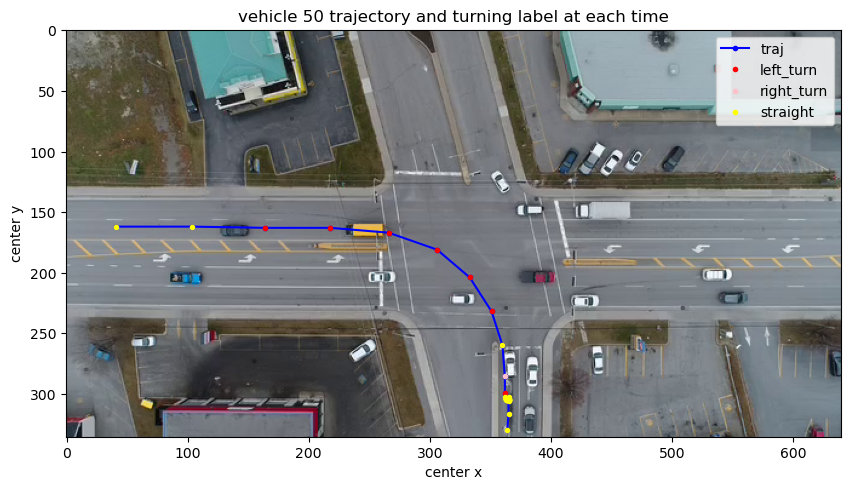

In [7]:
vehicle_id = 50

target_df = get_tra_from_id(df, vehicle_id)

turning_target_df = plot_turning_per_sec(target_df, vehicle_id)
plot_background_img()
plt.show()



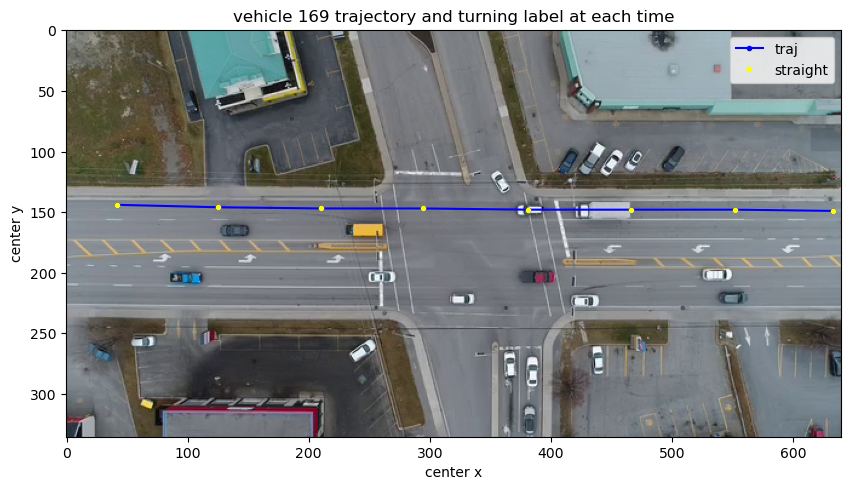

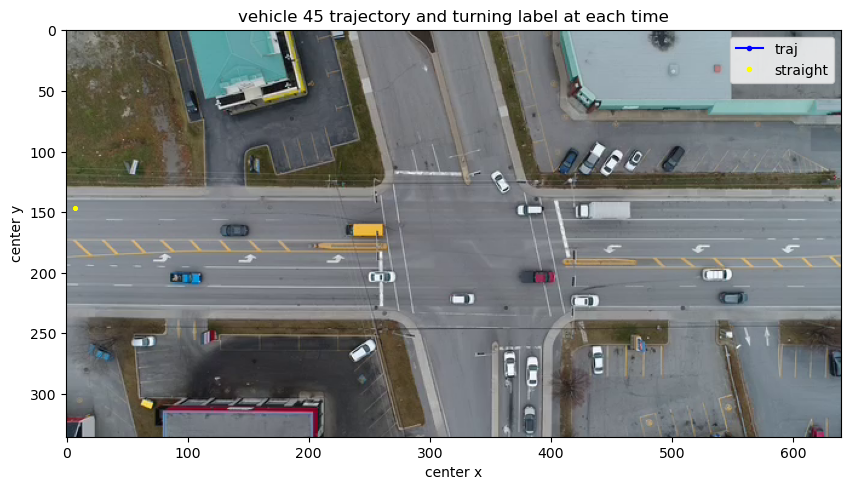

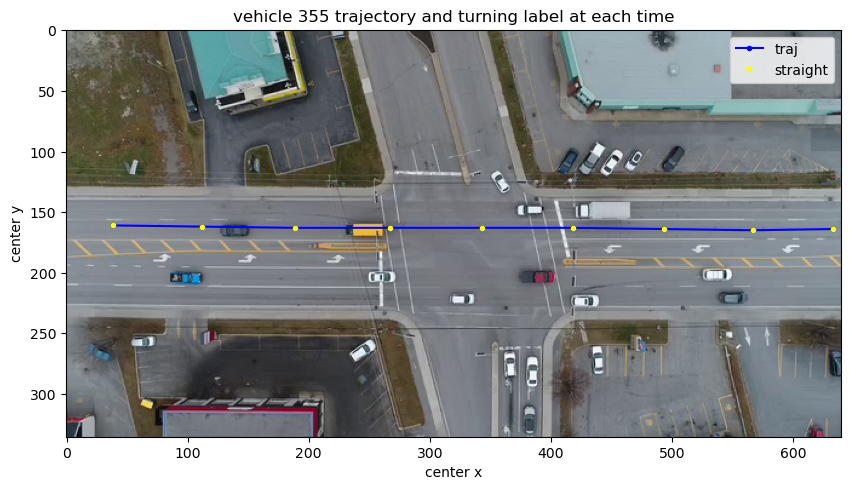

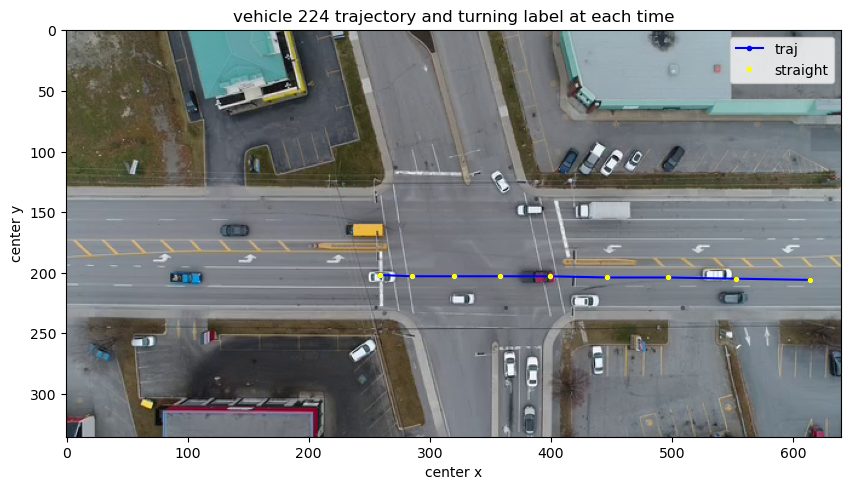

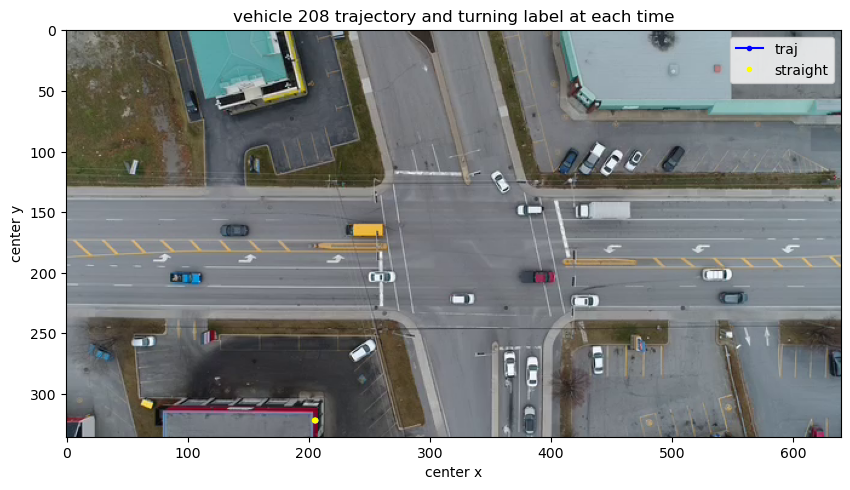

In [8]:
# 绘制5个不同车辆的轨迹图
for _ in range(5):
    
    vehicle_id = np.random.choice(df.id.unique())
    target_df = get_tra_from_id(df, vehicle_id)
    plot_turning_per_sec(target_df, vehicle_id)
    plot_background_img()

In [9]:
# 50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390

In [73]:
def refine_turning_label(df, vehicle_id, threshold=3):
    # 先对特定车辆的所有turn_label进行判断
    vehicle_df = df[df['id'] == vehicle_id].copy()

    # 计算每种转弯标签的数量
    left_turn_count = (vehicle_df['turn_label'] == 'left_turn').sum()
    right_turn_count = (vehicle_df['turn_label'] == 'right_turn').sum()

    # 如果 left_turn 的数量大于阈值，整体标记为 left_turn
    if left_turn_count >= threshold:
        vehicle_df['overall_turn_label'] = 'left_turn'
    # 如果没有足够的 left_turn，但 right_turn 的数量大于阈值，整体标记为 right_turn
    elif right_turn_count >= threshold:
        vehicle_df['overall_turn_label'] = 'right_turn'
    # 否则保持为 straight
    else:
        vehicle_df['overall_turn_label'] = 'straight'

    return vehicle_df

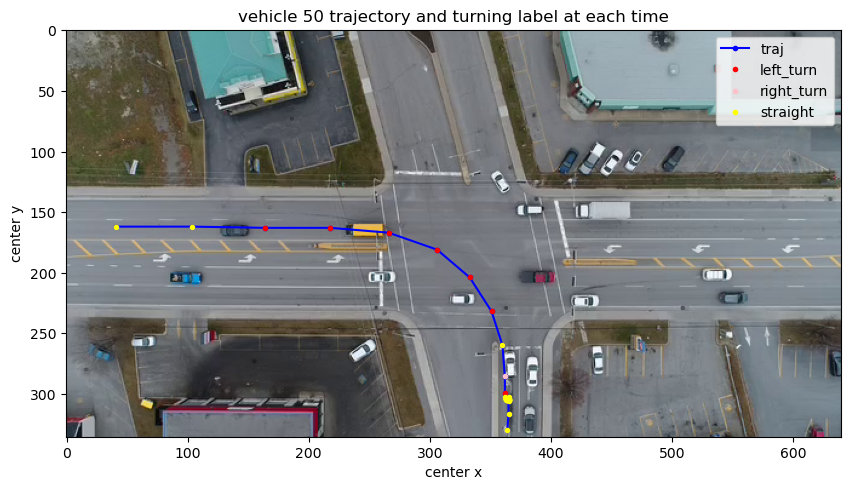

4581    left_turn
4582    left_turn
4583    left_turn
4584    left_turn
4585    left_turn
4586    left_turn
4587    left_turn
4588    left_turn
4589    left_turn
4590    left_turn
4591    left_turn
4592    left_turn
4593    left_turn
4594    left_turn
4595    left_turn
4596    left_turn
4597    left_turn
4598    left_turn
4599    left_turn
4600    left_turn
4601    left_turn
4602    left_turn
4603    left_turn
4604    left_turn
4605    left_turn
4606    left_turn
4607    left_turn
4608    left_turn
4609    left_turn
4610    left_turn
4611    left_turn
4612    left_turn
4613    left_turn
4614    left_turn
4615    left_turn
4616    left_turn
4617    left_turn
4618    left_turn
4619    left_turn
4620    left_turn
4621    left_turn
Name: overall_turn_label, dtype: object
turn_label
straight      33
left_turn      7
right_turn     1
Name: count, dtype: int64


In [90]:
# vehicle_id = np.random.choice([50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390])
vehicle_id = 50
target_df = get_tra_from_id(df, vehicle_id)

turning_target_df = plot_turning_per_sec(target_df, vehicle_id)
plot_background_img()
plt.show()

# Example usage
refined_df = refine_turning_label(turning_target_df, vehicle_id)

print(refined_df['overall_turn_label'])

print(turning_target_df.turn_label.value_counts())


In [75]:
# 50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390

In [76]:
turning_target_df

frame       time  id class  center_x  center_y  speed_kmh  \
0       1   0.034483   1   car       385       281        NaN   
1      31   1.068966   1   car       385       282   0.055364   
2      61   2.103448   1   car       385       281   0.110727   
3      91   3.137931   1   car       385       281   0.000000   
4     121   4.172414   1   car       385       281   0.000000   
5     151   5.206897   1   car       385       281   0.000000   
6     181   6.241379   1   car       385       281   0.000000   
7     211   7.275862   1   car       385       281   0.000000   
8     241   8.310345   1   car       385       281   0.000000   
9     271   9.344828   1   car       385       280   0.553636   
10    301  10.379310   1   car       385       281   0.553636   
11    331  11.413793   1   car       385       281   0.000000   
12    361  12.448276   1   car       385       280   0.553636   
13    391  13.482759   1   car       385       280   0.000000   
14    421  14.517241   1   car       385       280   0.000000   
15    451  15.551724   1   car       384       280   0.553636   
16    481  16.586207   1   car       384       281   0.110727   
17    511  17.620690   1   car       384       281   0.166091   
18    541  18.655172   1   car       384       280   0.276818   
19    571  19.689655   1   car       384       280   0.110727   
20    601  20.724138   1   car       384       280   0.000000   
21    631  21.758621   1   car       384       281   0.055364   
22    661  22.793103   1   car       383       281   0.737095   
23    691  23.827586   1   car       383       281   0.000000   
24    721  24.862069   1   car       383       282   0.055364   
25    751  25.896552   1   car       383       281   0.166091   
26    781  26.931034   1   car       383       281   0.000000   
27    811  27.965517   1   car       383       280   0.553636   
28    841  29.000000   1   car       383       280   0.055364   
29    871  30.034483   1   car       383       281   0.442909   
30    901  31.068966   1   car       383       281   0.000000   
31    931  32.103448   1   car       383       281   0.000000   
32    961  33.137931   1   car       382       281   0.078296   
33    991  34.172414   1   car       382       281   0.442909   
34   1021  35.206897   1   car       382       281   0.000000   
35   1051  36.241379   1   car       382       281   0.000000   
36   1081  37.275862   1   car       382       281   0.000000   
37   1111  38.310345   1   car       382       281   0.000000   
38   1141  39.344828   1   car       382       281   0.000000   
39   1171  40.379310   1   car       381       280   0.189023   
40   1201  41.413793   1   car       381       280   0.612935   
41   1231  42.448276   1   car       381       280   0.521205   
42   1261  43.482759   1   car       381       280   0.442909   
43   1291  44.517241   1   car       381       276   1.660909   
44   1321  45.551724   1   car       381       260   7.476394   
45   1351  46.586207   1   car       387       239  11.520971   
46   1381  47.620690   1   car       405       222  13.161826   
47   1411  48.655172   1   car       432       216  14.460492   
48   1441  49.689655   1   car       464       217  17.005653   
49   1471  50.724138   1   car       500       219  19.125349   
50   1501  51.758621   1   car       541       219  21.260384   
51   1531  52.793103   1   car       587       220  24.366292   
52   1561  53.827586   1   car       630       220  24.636818   

    center_y_inverted  delta_x  delta_y     theta  delta_theta  \
0                -281      NaN      NaN       NaN     0.000000   
1                -282      0.0     -1.0 -1.570796     0.000000   
2                -281      0.0      1.0  1.570796    -3.141593   
3                -281      0.0      0.0  0.000000    -1.570796   
4                -281      0.0      0.0  0.000000     0.000000   
5                -281      0.0      0.0  0.000000     0.000000   
6                -281      0.0 

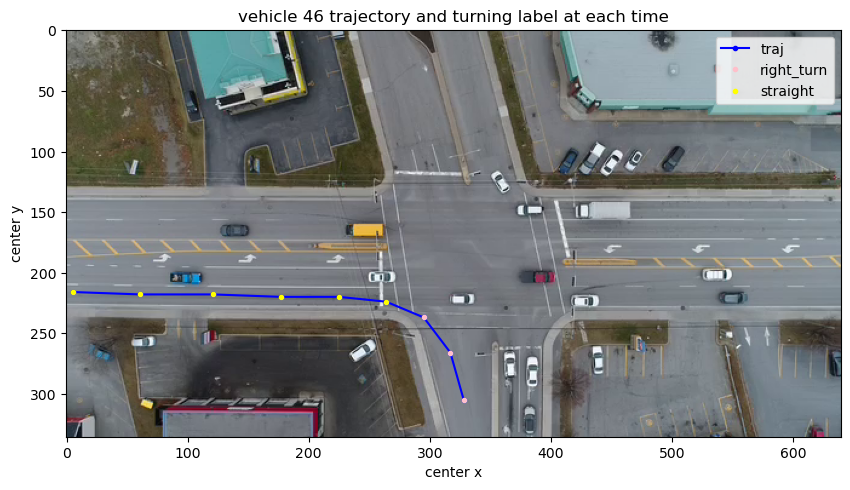

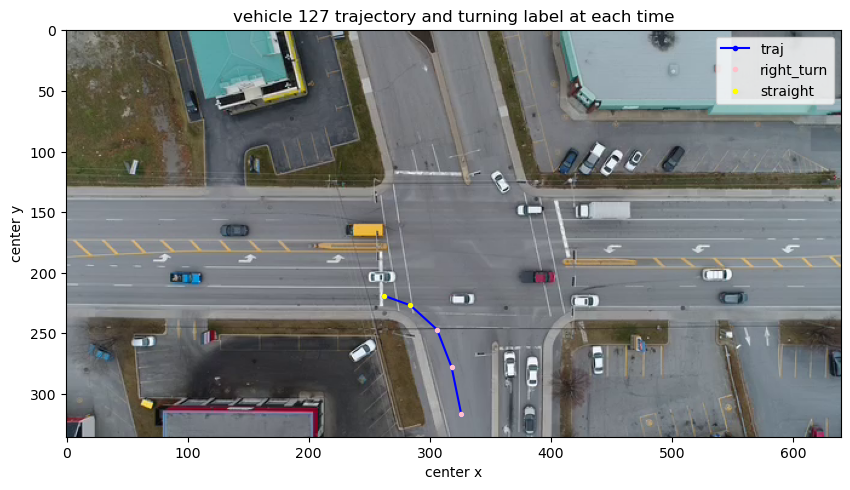

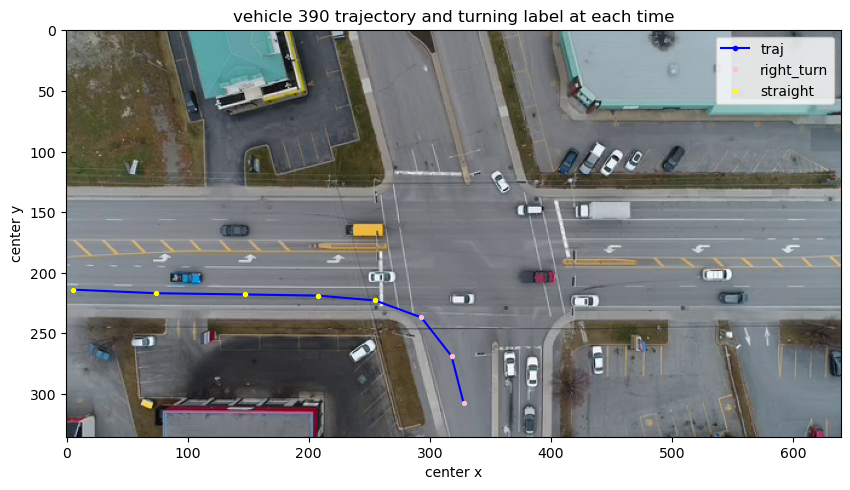

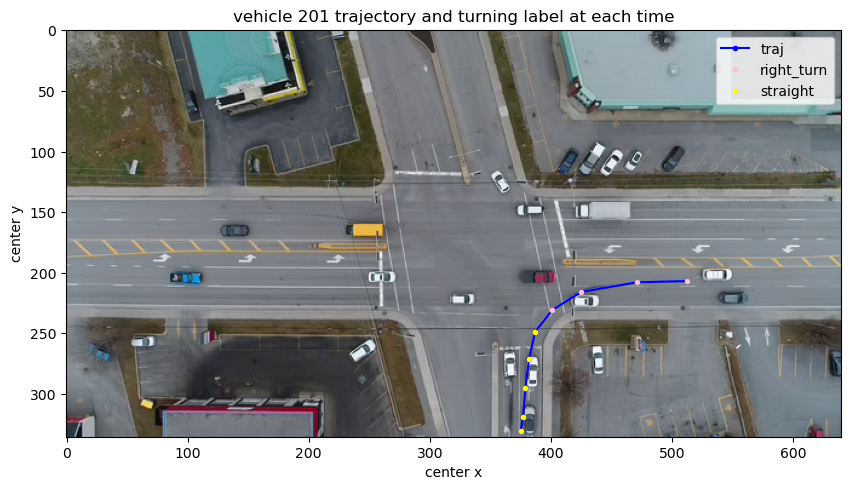

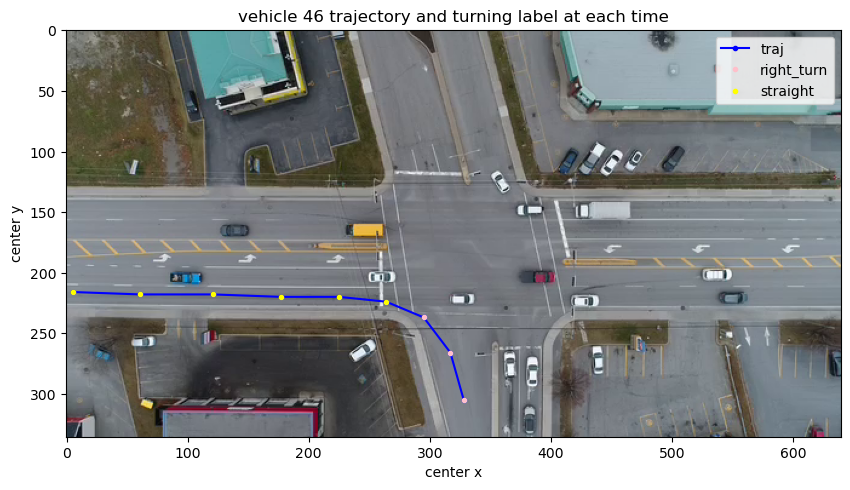

In [77]:
# 绘制5个不同车辆的轨迹图
for _ in range(5):
    
    vehicle_id = np.random.choice([50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390])
    target_df = get_tra_from_id(df, vehicle_id)
    plot_turning_per_sec(target_df, vehicle_id)
    plot_background_img()

In [78]:


def calc_turning_per_sec(df, vehicle_id, deg_thresh=10):
    df['center_y_inverted'] = df['center_y'] * -1
    


    
    # 计算每个车辆在每个时间点的位移
    df.loc[:, 'delta_x'] = df.groupby('id')['center_x'].diff()
    df.loc[:, 'delta_y'] = df.groupby('id')['center_y_inverted'].diff()
    
    # 计算每个点的方向角（弧度），范围为 [-π, π]
    df.loc[:, 'theta'] = np.arctan2(df['delta_y'], df['delta_x'])

    # 计算方向角的变化量（角速度）
    df.loc[:, 'delta_theta'] = df.groupby('id')['theta'].diff()
    
    # 为了处理角度跳变的问题，将变化量限制在 [-π, π] 范围内
    df.loc[:, 'delta_theta'] = (df['delta_theta'] + np.pi) % (2 * np.pi) - np.pi
    
    # 填充缺失值
    df.loc[:, 'delta_theta'] = df['delta_theta'].fillna(0)
    
    # 设置角度变化累积的窗口大小，例如3秒（假设帧率为30帧/秒）
    window_size = 2  # 2秒 
    
    # 对角度变化进行累积和
    df.loc[:, 'cum_delta_theta'] = df.groupby('id')['delta_theta'].rolling(window_size).sum().reset_index(level=0, drop=True)
    
    # 设置窗口大小（可以根据需要调整）
    
    
    # 使用滑动窗口来计算累积方向变化
    df.loc[:, 'windowed_delta_theta'] = df['delta_theta'].rolling(window=window_size, min_periods=1).sum()
    
    # 设置阈值来判断转弯方向
    turn_threshold = np.deg2rad(deg_thresh)  # 15度的阈值
    
    # 初始化转弯标签
    df['turn_label'] = 'straight'  # 默认为直行
    
    # 计算像素上的移动距离
    df['distance_moved'] = np.sqrt(df['delta_x'] ** 2 + df['delta_y'] ** 2)
    
    # 将像素转换为米，1个像素对应 3.5/19 米
    df['distance_moved_meters'] = df['distance_moved'] * (3.5 / 19)
    
    # 设置移动距离的阈值，低于该阈值表示车辆没有实际移动
    movement_threshold = 0.5  # 阈值设为0.5米（可以根据实际情况调整）
    
    # 判断左转，仅当车辆实际移动的距离超过阈值时才标记为转弯
    df.loc[(df['windowed_delta_theta'] > turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'left_turn'
    
    # 判断右转
    df.loc[(df['windowed_delta_theta'] < -turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'right_turn'

    return df
    
    # plt.show() 

In [79]:
def process_all_vehicle_ids(df):
    all_refined_dfs = []  # 用于存储所有处理后的数据
    
    # 按id分组
    for vehicle_id, group in df.groupby('id'):
        print(f"Processing vehicle_id: {vehicle_id}")
        
        # 获取当前车辆的数据
        target_df = get_tra_from_id(df, vehicle_id)
        
        # 计算转弯标签
        turning_target_df = calc_turning_per_sec(target_df, vehicle_id)
        
        # 应用 refine_turning_label 来生成精简后的转弯标签
        refined_df = refine_turning_label(turning_target_df, vehicle_id)
        
        # 将处理后的结果添加到列表中
        all_refined_dfs.append(refined_df)
    
    # 将所有处理后的数据框合并
    final_df = pd.concat(all_refined_dfs, ignore_index=True)
    
    return final_df


# Example usage:
final_df = process_all_vehicle_ids(df)

# 打印所有处理后的转弯标签统计
print(final_df['turn_label'].value_counts())

# 可以选择进一步的操作，比如保存或可视化

Processing vehicle_id: 1
Processing vehicle_id: 2
Processing vehicle_id: 3
Processing vehicle_id: 4
Processing vehicle_id: 5
Processing vehicle_id: 6
Processing vehicle_id: 7
Processing vehicle_id: 8
Processing vehicle_id: 9
Processing vehicle_id: 10
Processing vehicle_id: 11
Processing vehicle_id: 12
Processing vehicle_id: 13
Processing vehicle_id: 14
Processing vehicle_id: 15
Processing vehicle_id: 16
Processing vehicle_id: 17
Processing vehicle_id: 18
Processing vehicle_id: 19
Processing vehicle_id: 20
Processing vehicle_id: 21
Processing vehicle_id: 22
Processing vehicle_id: 23
Processing vehicle_id: 24
Processing vehicle_id: 25
Processing vehicle_id: 26
Processing vehicle_id: 27
Processing vehicle_id: 28
Processing vehicle_id: 29
Processing vehicle_id: 30
Processing vehicle_id: 32
Processing vehicle_id: 33
Processing vehicle_id: 34
Processing vehicle_id: 35
Processing vehicle_id: 36
Processing vehicle_id: 37
Processing vehicle_id: 38
Processing vehicle_id: 39
Processing vehicle_id

In [80]:
final_df.head()

frame      time  id class  center_x  center_y  speed_kmh  \
0      1  0.034483   1   car       385       281        NaN   
1     31  1.068966   1   car       385       282   0.055364   
2     61  2.103448   1   car       385       281   0.110727   
3     91  3.137931   1   car       385       281   0.000000   
4    121  4.172414   1   car       385       281   0.000000   

   center_y_inverted  delta_x  delta_y     theta  delta_theta  \
0               -281      NaN      NaN       NaN     0.000000   
1               -282      0.0     -1.0 -1.570796     0.000000   
2               -281      0.0      1.0  1.570796    -3.141593   
3               -281      0.0      0.0  0.000000    -1.570796   
4               -281      0.0      0.0  0.000000     0.000000   

   cum_delta_theta  windowed_delta_theta turn_label  distance_moved  \
0              NaN              0.000000   straight             NaN   
1         0.000000              0.000000   straight             1.0   
2        -3.141593             -3.141593   straight             1.0   
3        -4.712389             -4.712389   straight             0.0   
4        -1.570796             -1.570796   straight             0.0   

   distance_moved_meters overall_turn_label  
0                    NaN         right_turn  
1               0.184211         right_turn  
2               0.184211         right_turn  
3               0.000000         right_turn  
4               0.000000         right_turn

In [94]:
final_df.to_csv('csv_out/overall_turn_label.csv', index=False)